In [2]:
import os
import pandas as pd
import scanpy as sc
import numpy as np
import jax.tree_util as jtu
import anndata as ad
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.sparse import issparse
from scipy.stats import pearsonr, spearmanr
from collections import defaultdict

cmap = sns.color_palette("coolwarm", as_cmap=True)
cell_line_order = ['HAP1', 'K562', 'A549', 'HT29', 'MCF7', 'BXPC3', 'BXPC3 (predicted)']

In [7]:
def load_data(ood_combination):
    predictions_path = f'/lustre/groups/ml01/workspace/alessandro.palma/ot_pert/out/results_metrics/generated_data/sweep_cell_line_pathway/adata_ood_split_{ood_combination}.h5ad'
    train_path = f'/lustre/groups/ml01/workspace/ot_perturbation/data/satija/datasets/adata_ood_final_pathway_cell_type/{ood_combination}/adata_train_{ood_combination}.h5ad'
    test_path = f'/lustre/groups/ml01/workspace/ot_perturbation/data/satija/datasets/adata_ood_final_pathway_cell_type/{ood_combination}/adata_test_{ood_combination}.h5ad'
    ood_path = f'/lustre/groups/ml01/workspace/ot_perturbation/data/satija/datasets/adata_ood_final_pathway_cell_type/{ood_combination}/adata_ood_{ood_combination}.h5ad'

    predictions = sc.read_h5ad(predictions_path)
    train = sc.read_h5ad(train_path)
    test = sc.read_h5ad(test_path)
    ood = sc.read_h5ad(ood_path)

    # generate dicts for jtu tree_map
    ood_target = ood[ood.obs['gene'] != 'NT', :]
    ood_source = ood[ood.obs['gene'] == 'NT', :]
    ood_target_dict = {c: ood_target[ood_target.obs['condition'] == c, :].X for c in ood_target.obs['condition'].unique()}
    ood_source_dict = {c: ood_source[ood_source.obs['pathway'] == c.split('_')[1], :].X for c in ood_target.obs['condition'].unique()}
    ood_prediction = {c: predictions[predictions.obs['condition'] == c].layers['X_recon_pred'] for c in predictions.obs['condition'].unique()}

    train = ad.concat([train, test])
    train_target = train[train.obs['gene'] != 'NT', :]
    train_source = train[train.obs['gene'] == 'NT', :]
    train_target_dict = {c: train_target[train_target.obs['condition'] == c, :].X for c in train_target.obs['condition'].unique()}
    train_source_dict = {c: train_source[train_source.obs['pathway'] == c.split('_')[1], :].X for c in train_target.obs['condition'].unique()}

    ood_genes = ood.var_names
    train_genes = train.var_names

    return ood_target_dict, ood_source_dict, ood_prediction, train_target_dict, train_source_dict, ood_genes, train_genes

def calc_zscores(sample1, sample2):
    if issparse(sample1):
        sample1 = sample1.toarray()
    if issparse(sample2):
        sample2 = sample2.toarray()

    mean1 = sample1.mean(axis=0)
    std1 = sample1.std(axis=0)
    mean2 = sample2.mean(axis=0)
    std2 = sample2.std(axis=0)
    
    n1 = sample1.shape[0]
    n2 = sample2.shape[0]
    se = np.sqrt((std1**2 / n1) + (std2**2 / n2))
    
    z_scores = (mean1 - mean2) / se
    return z_scores

def get_zscores(ood_target_dict, ood_source_dict, ood_prediction, train_target_dict, train_source_dict, ood_genes, train_genes):
    ood_zscores = jtu.tree_map(calc_zscores, ood_target_dict, ood_source_dict)
    prediction_zscores = jtu.tree_map(calc_zscores, ood_prediction, ood_source_dict)
    train_zscores = jtu.tree_map(calc_zscores, train_target_dict, train_source_dict)

    df_train = []
    for key, value in train_zscores.items():
        df_train.append(pd.DataFrame({
            'predicted': False,
            'cell_line': key.split('_')[0],
            'pathway': key.split('_')[1],
            'knockout': key.split('_')[2],
            'gene': list(train_genes),
            'zscore': value
        }))
    df_train = pd.concat(df_train)

    df_ood = []
    for key, value in ood_zscores.items():
        df_ood.append(pd.DataFrame({
            'predicted': False,
            'cell_line': key.split('_')[0],
            'pathway': key.split('_')[1],
            'knockout': key.split('_')[2],
            'gene': list(ood_genes),
            'zscore': value
        }))
    df_ood = pd.concat(df_ood)

    df_prediction = []
    for key, value in prediction_zscores.items():
        df_prediction.append(pd.DataFrame({
            'predicted': True,
            'cell_line': key.split('_')[0] + ' (predicted)',
            'pathway': key.split('_')[1],
            'knockout': key.split('_')[2],
            'gene': list(ood_genes),
            'zscore': value
        }))
    df_predicted = pd.concat(df_prediction)
    df_predicted_filtered = df_predicted[df_predicted['zscore'].notna()]

    df_ground_truth = pd.concat([df_train, df_ood])
    df_ground_truth_filtered = df_ground_truth[df_ground_truth['zscore'].notna()]

    df_zscores = pd.concat([df_ground_truth, df_predicted])
    
    return df_zscores, df_ground_truth_filtered, df_predicted_filtered


def plot_heatmaps_by_knockout(df, vmin=-15,vmax=15, cell_line_order=cell_line_order):
    knockouts = df['knockout'].unique()
    for knockout in knockouts:
        knockout_df = df[df['knockout'] == knockout]

        if cell_line_order is not None:
            knockout_df['cell_line'] = pd.Categorical(knockout_df['cell_line'], categories=cell_line_order, ordered=True)
            knockout_df = knockout_df.sort_values('cell_line')
            
        heatmap_data = knockout_df.pivot(index='cell_line', columns='gene', values='zscore')

        plt.figure(figsize=(10, 6)) 
        sns.heatmap(
            heatmap_data,
            cmap=cmap,
            vmin=vmin,
            vmax=vmax,
            cbar_kws={'label': 'Z-Score'}
        )
        plt.title(f"Heatmap for Knockout: {knockout}")
        plt.xlabel("Gene")
        plt.ylabel("Cell Line")
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

def plot_heatmaps_by_knockout_ordered(df, vmin=-15, vmax=15, cell_line_order=None):
    ood_cell_line = df[df['predicted']]['cell_line'].unique()[0].split(' ')[0]
    
    knockouts = df['knockout'].unique()
    for knockout in knockouts:
        knockout_df = df[df['knockout'] == knockout]

        # Order cell lines
        if cell_line_order is not None:
            knockout_df['cell_line'] = pd.Categorical(knockout_df['cell_line'], categories=cell_line_order, ordered=True)
            knockout_df = knockout_df.sort_values('cell_line')
        
        # Determine gene order by z-scores in the ood cell line
        ood_cell_line_genes = knockout_df[knockout_df['cell_line'] == ood_cell_line][['gene', 'zscore']].dropna()
        gene_order = ood_cell_line_genes.sort_values('zscore', ascending=False)['gene'].tolist()

        # Pivot the data
        heatmap_data = knockout_df.pivot(index='cell_line', columns='gene', values='zscore')

        # Reorder the columns (genes) by ood cell line z-scores
        heatmap_data = heatmap_data[gene_order]

        # Plot heatmap
        plt.figure(figsize=(10, 6))
        sns.heatmap(
            heatmap_data,
            cmap='coolwarm',
            vmin=vmin,
            vmax=vmax,
            cbar_kws={'label': 'Z-Score'}
        )
        plt.title(f"Heatmap for Knockout: {knockout}")
        plt.xlabel("Gene")
        plt.ylabel("Cell Line")
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
    
def filter_deg(df, deg):
    filtered_frames = []
    for key, genes in deg.items():
        cell_line, pathway, knockout = key.split('_')        
        filtered_df = df[
            (df['cell_line'] == cell_line) &
            (df['pathway'] == pathway) &
            (df['knockout'] == knockout) &
            (df['gene'].isin(genes))
        ]
        
        filtered_frames.append(filtered_df)
    final_filtered_df = pd.concat(filtered_frames, ignore_index=True)
    return final_filtered_df

def filter_deg_optimized(df, deg):
    df['key'] = df['cell_line'] + '_' + df['pathway'] + '_' + df['knockout']
    dict_df = (
        pd.DataFrame([(key, gene) for key, genes in deg.items() for gene in genes], columns=['key', 'gene'])
    )
    filtered_df = pd.merge(df, dict_df, on=['key', 'gene'], how='inner')
    filtered_df = filtered_df.drop(columns=['key'])
    return filtered_df

def calculate_similarities(df_predicted, df_measured):
    results = []
    for pred_cell in df_predicted['cell_line'].unique():
        pred_data = df_predicted[df_predicted['cell_line'] == pred_cell]
        for measured_cell in df_measured['cell_line'].unique():
            measured_data = df_measured[df_measured['cell_line'] == measured_cell]
            merged = pd.merge(
                pred_data, 
                measured_data, 
                on=['pathway', 'knockout', 'gene'], 
                suffixes=('_pred', '_non')
            )
            
            if not merged.empty:
                abs_diff = np.abs(merged['zscore_pred'] - merged['zscore_non'])
                mae = np.mean(abs_diff)
                
                if len(merged) > 1:  # Correlations require at least two data points
                    pearson_corr, _ = pearsonr(merged['zscore_pred'], merged['zscore_non'])
                    spearman_corr, _ = spearmanr(merged['zscore_pred'], merged['zscore_non'])
                else:
                    pearson_corr = np.nan
                    spearman_corr = np.nan
                
                results.append({
                    'cell_line_predicted': pred_cell,
                    'cell_line': measured_cell,
                    'pearson_correlation': pearson_corr,
                    'spearman_correlation': spearman_corr,
                    'MAE': mae
                })
    df_results = pd.DataFrame(results)
    return df_results

In [4]:
ood_combinations = ["A549_IFNB", "BXPC3_IFNG", "HAP1_TGFB", "HT29_TNFA", "K562_INS"]

## A549_IFNB

In [9]:
ood_combination = ood_combinations[0]
ood_target, ood_source, ood_prediction, train_target, train_source = load_data(ood_combination)

In [11]:
df_zscores, df_ground_truth_filtered, df_predicted_filtered = get_zscores(ood_target, ood_source, ood_prediction, train_target, train_source)

/tmp/ipykernel_2782980/1004791901.py:42: RuntimeWarning: invalid value encountered in divide
  z_scores = (mean1 - mean2) / se


/tmp/ipykernel_2782980/264133250.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  knockout_df['cell_line'] = pd.Categorical(knockout_df['cell_line'], categories=cell_line_order, ordered=True)


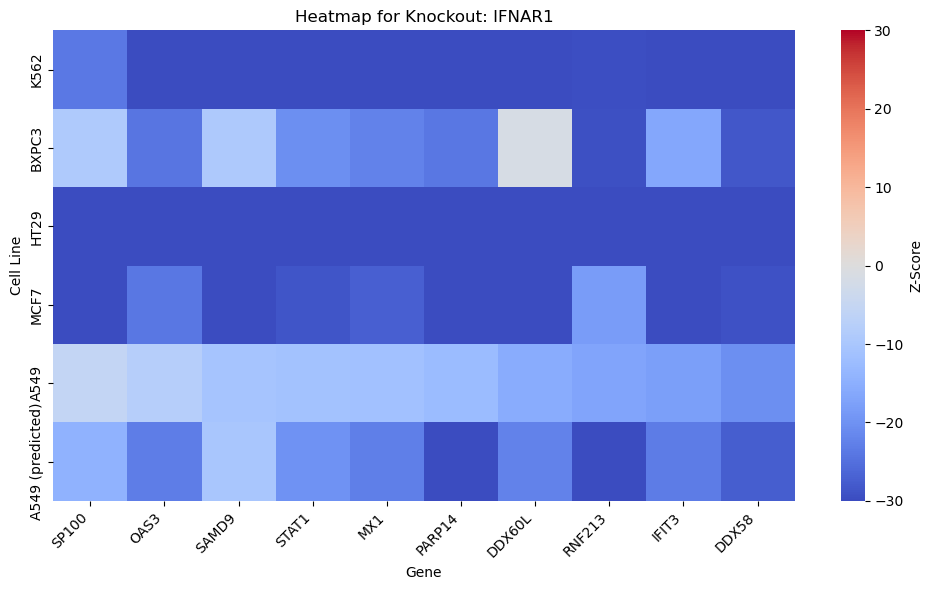

/tmp/ipykernel_2782980/264133250.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  knockout_df['cell_line'] = pd.Categorical(knockout_df['cell_line'], categories=cell_line_order, ordered=True)
/lustre/groups/ml01/workspace/lea.zimmermann/software/miniconda3/envs/cfp2/lib/python3.10/site-packages/seaborn/matrix.py:309: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))


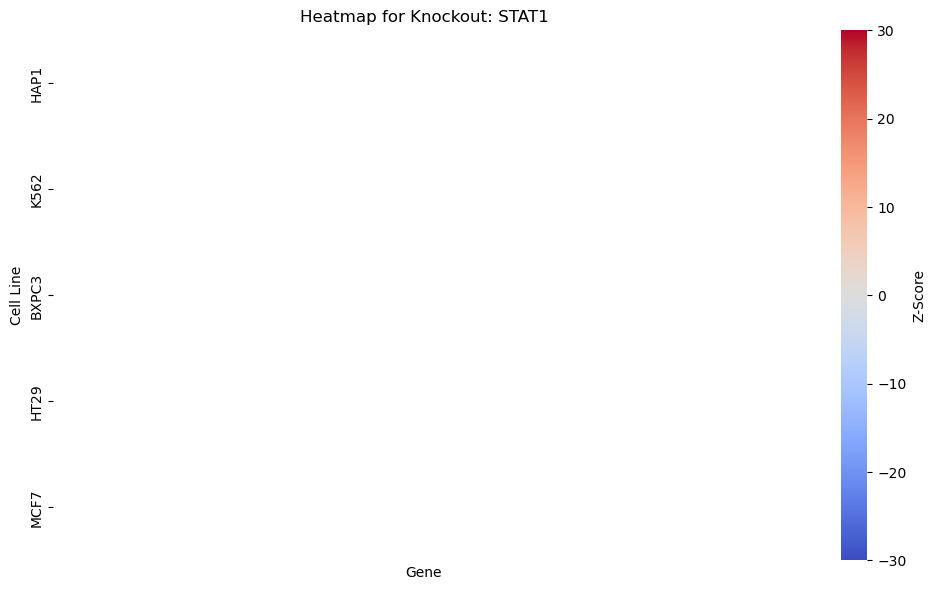

/tmp/ipykernel_2782980/264133250.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  knockout_df['cell_line'] = pd.Categorical(knockout_df['cell_line'], categories=cell_line_order, ordered=True)


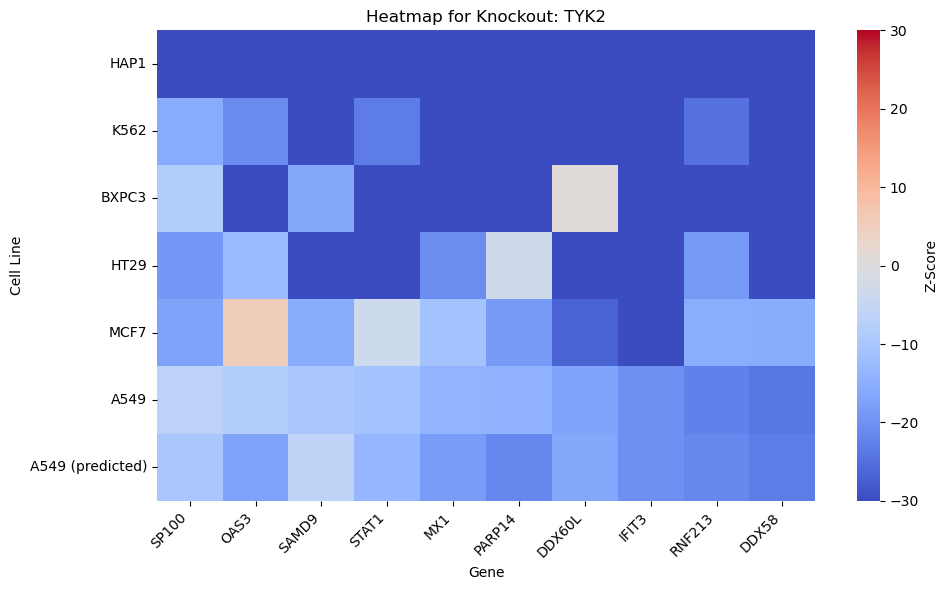

/tmp/ipykernel_2782980/264133250.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  knockout_df['cell_line'] = pd.Categorical(knockout_df['cell_line'], categories=cell_line_order, ordered=True)


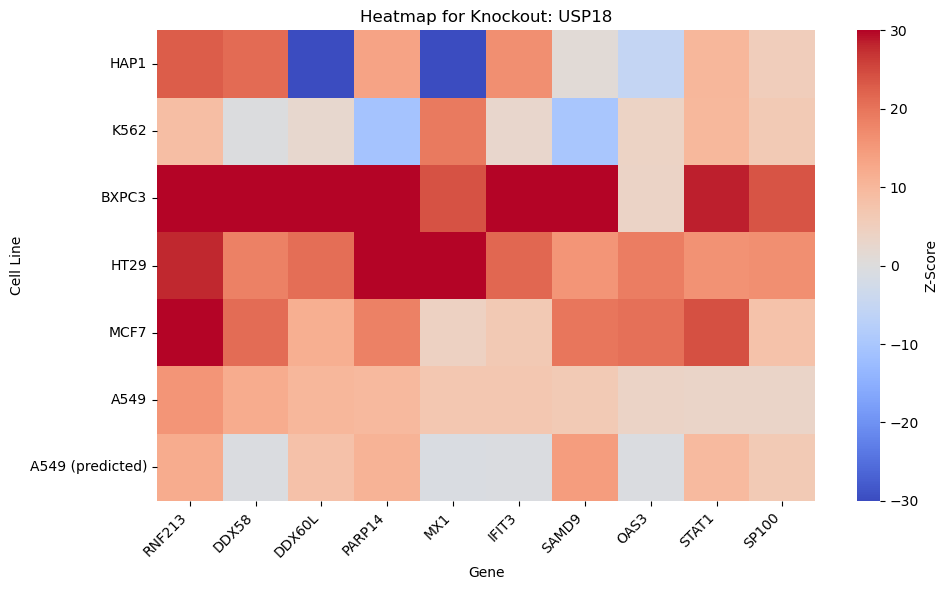

In [23]:
knockouts = ['IFNAR1', 'STAT1', 'TYK2', 'USP18']
pathways = ['IFNB']
cell_types = ['A549 (predicted)', 'BXPC3', 'HAP1', 'K562', 'A549', 'HT29', 'MCF7']
genes = genes = ["STAT1", "SP100", "SAMD9", "RNF213", "PARP14", "OAS3", "MX1", "IFIT3", "DDX60L", "DDX58"]

df_uc1 = df_zscores[
    df_zscores['knockout'].isin(knockouts) &
    df_zscores['pathway'].isin(pathways) &
    df_zscores['cell_line'].isin(cell_types) &
    df_zscores['gene'].isin(genes)
]

plot_heatmaps_by_knockout_ordered(df_uc1, vmin=-30, vmax=30, cell_line_order = ['HAP1', 'K562', 'BXPC3', 'HT29', 'MCF7', 'A549', 'A549 (predicted)'])

In [24]:
df_results = calculate_similarities(df_predicted_filtered, df_ground_truth_filtered)
df_results

,cell_line_predicted,cell_line,pearson_correlation,spearman_correlation,MAE
0,A549 (predicted),A549,0.325669,0.413627,5.023617
1,A549 (predicted),BXPC3,0.073925,0.048405,14.568913
2,A549 (predicted),HAP1,0.101831,0.078221,15.238942
3,A549 (predicted),HT29,0.148537,0.133594,15.554023
4,A549 (predicted),K562,0.125271,0.042666,15.974419
5,A549 (predicted),MCF7,0.094122,0.049546,15.581287


In [25]:
# quantification only for genes in heatmap
df_predicted_heatmaps = df_predicted_filtered.query('gene in @genes and knockout in @knockouts')
df_ground_truth_heatmaps = df_ground_truth_filtered.query('gene in @genes and knockout in @knockouts')

In [26]:
df_results_heatmaps = calculate_similarities(df_predicted_heatmaps, df_ground_truth_heatmaps)
df_results_heatmaps

,cell_line_predicted,cell_line,pearson_correlation,spearman_correlation,MAE
0,A549 (predicted),A549,0.887530,0.837597,6.150944
1,A549 (predicted),BXPC3,0.851024,0.773526,18.525951
2,A549 (predicted),HAP1,0.642193,0.536842,43.878914
3,A549 (predicted),HT29,0.830407,0.775306,23.168949
4,A549 (predicted),K562,0.743211,0.713014,15.024612
5,A549 (predicted),MCF7,0.834545,0.765517,10.614629


## HAP1_TGFB

In [29]:
ood_combination = ood_combinations[2]
ood_target, ood_source, ood_prediction, train_target, train_source = load_data(ood_combination)
df_zscores, df_ground_truth_filtered, df_predicted_filtered = get_zscores(ood_target, ood_source, ood_prediction, train_target, train_source)

/tmp/ipykernel_2782980/264133250.py:42: RuntimeWarning: invalid value encountered in divide
  z_scores = (mean1 - mean2) / se


In [32]:
df_zscores

,predicted,cell_line,pathway,knockout,gene,zscore
0,False,A549,IFNB,CEBPG,A2M,-3.741947
1,False,A549,IFNB,CEBPG,A2M-AS1,-3.313955
2,False,A549,IFNB,CEBPG,A4GNT,NaN
3,False,A549,IFNB,CEBPG,AADACL2,-2.952197
4,False,A549,IFNB,CEBPG,AADAT,1.930442
...,...,...,...,...,...,...
8260,True,HAP1 (predicted),TGFB,TGIF1,ZSCAN10,23.523968
8261,True,HAP1 (predicted),TGFB,TGIF1,ZSCAN12P1,10.132726
8262,True,HAP1 (predicted),TGFB,TGIF1,ZSCAN5A,0.568571
8263,True,HAP1 (predicted),TGFB,TGIF1,ZSCAN5DP,15.526872


/tmp/ipykernel_2782980/264133250.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  knockout_df['cell_line'] = pd.Categorical(knockout_df['cell_line'], categories=cell_line_order, ordered=True)


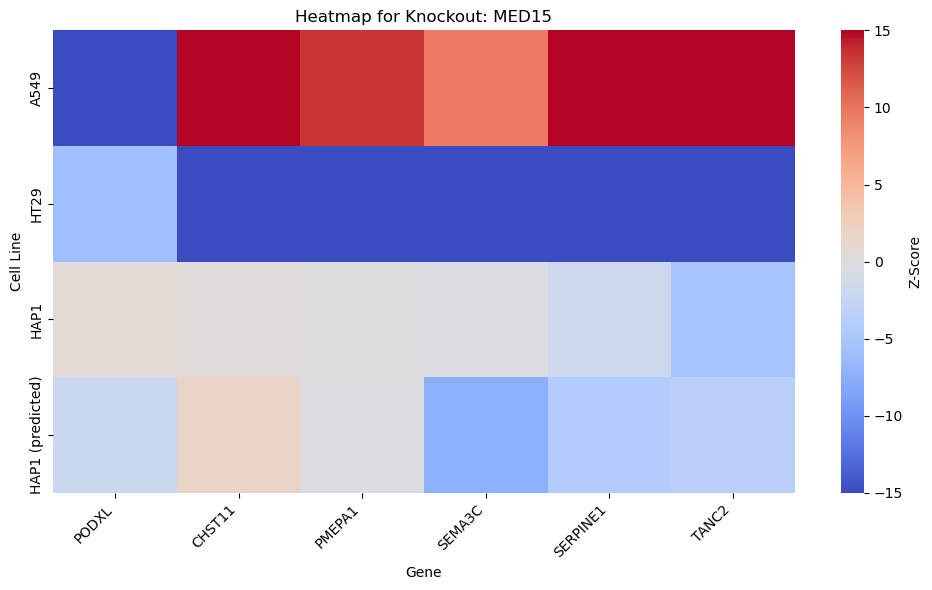

/tmp/ipykernel_2782980/264133250.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  knockout_df['cell_line'] = pd.Categorical(knockout_df['cell_line'], categories=cell_line_order, ordered=True)


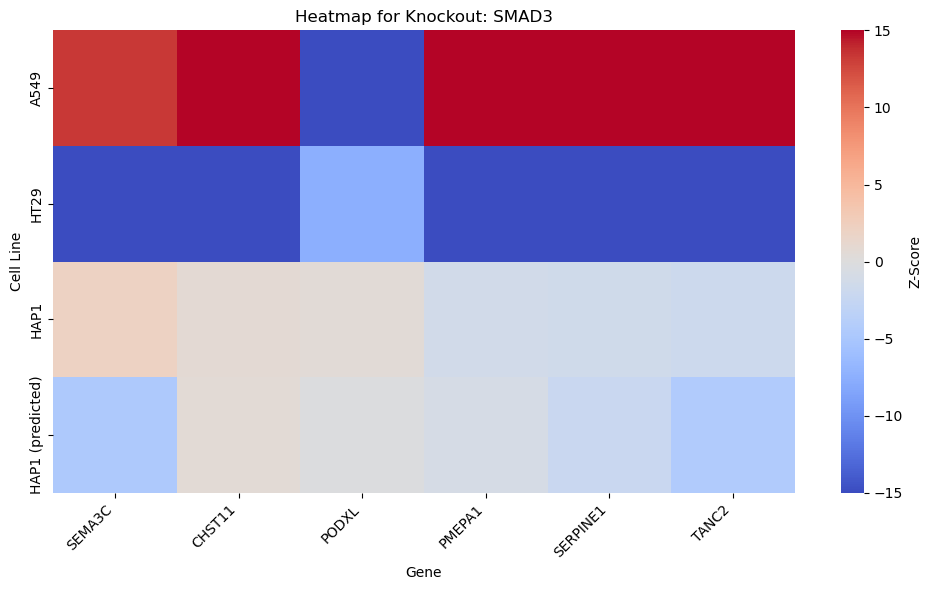

/tmp/ipykernel_2782980/264133250.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  knockout_df['cell_line'] = pd.Categorical(knockout_df['cell_line'], categories=cell_line_order, ordered=True)


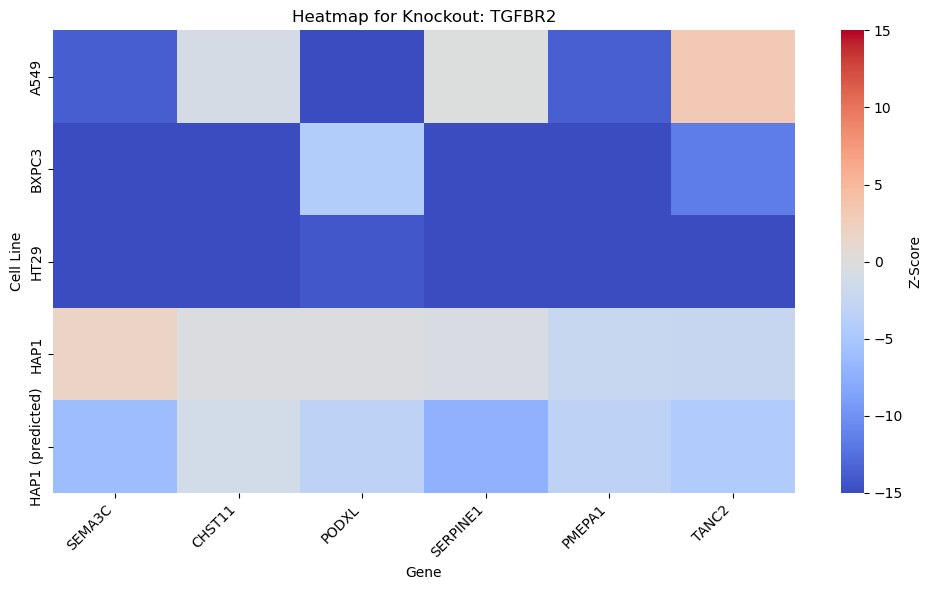

/tmp/ipykernel_2782980/264133250.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  knockout_df['cell_line'] = pd.Categorical(knockout_df['cell_line'], categories=cell_line_order, ordered=True)


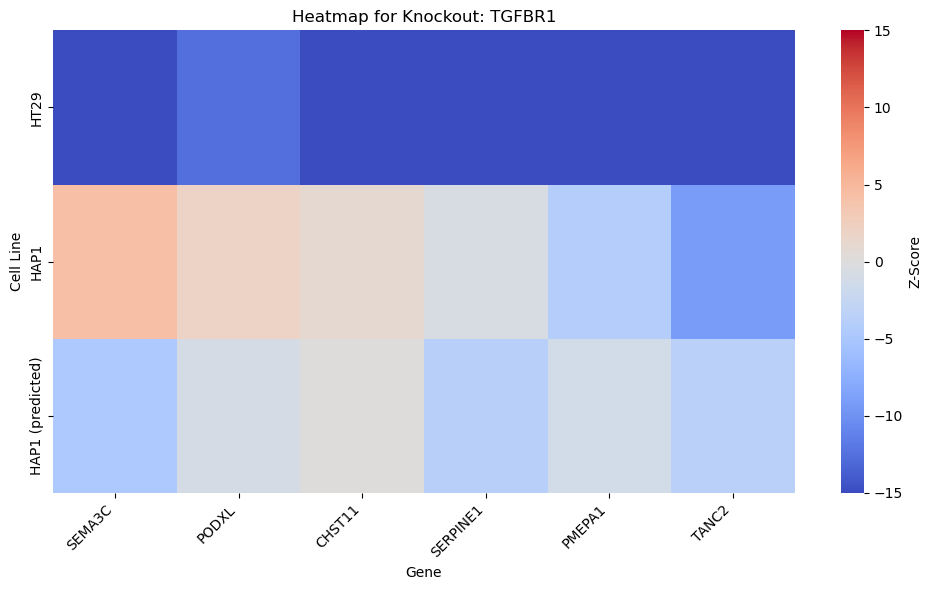

In [35]:
knockouts = ["MED15", "SMAD3", "TGFBR1", "TGFBR2"]
pathways = ['TGFB']
cell_types = ['HAP1 (predicted)', 'BXPC3', 'HAP1', 'K562', 'A549', 'HT29', 'MCF7']
genes = ["TGFB1", "TANC2", "SERPINE1", "SEMA3C", "PTPRK", "PODXL", "PMEPA1", "MYO10", "ITGB1", "CHST11"]

df = df_zscores[
    df_zscores['knockout'].isin(knockouts) &
    df_zscores['pathway'].isin(pathways) &
    df_zscores['cell_line'].isin(cell_types) &
    df_zscores['gene'].isin(genes)
]

plot_heatmaps_by_knockout_ordered(df, cell_line_order = ['A549', 'K562', 'BXPC3', 'HT29', 'MCF7', 'HAP1', 'HAP1 (predicted)'])

In [36]:
df_results = calculate_similarities(df_predicted_filtered, df_ground_truth_filtered)
df_results

,cell_line_predicted,cell_line,pearson_correlation,spearman_correlation,MAE
0,HAP1 (predicted),A549,0.042854,0.021182,13.647967
1,HAP1 (predicted),BXPC3,0.031798,-0.049899,13.809571
2,HAP1 (predicted),HAP1,0.400080,0.515457,6.519479
3,HAP1 (predicted),HT29,0.125471,0.130363,13.735384
4,HAP1 (predicted),MCF7,0.080005,0.048760,14.216818


In [37]:
# quantification only for genes in heatmap
df_predicted_heatmaps = df_predicted_filtered.query('gene in @genes and knockout in @knockouts')
df_ground_truth_heatmaps = df_ground_truth_filtered.query('gene in @genes and knockout in @knockouts')
df_results_heatmaps = calculate_similarities(df_predicted_heatmaps, df_ground_truth_heatmaps)
df_results_heatmaps

,cell_line_predicted,cell_line,pearson_correlation,spearman_correlation,MAE
0,HAP1 (predicted),A549,0.094457,0.112487,24.539261
1,HAP1 (predicted),BXPC3,-0.287578,-0.028571,19.847254
2,HAP1 (predicted),HT29,0.012639,0.046087,33.458450
3,HAP1 (predicted),HAP1,0.068874,0.159130,3.042677


## HT29_TNFA

At least in plot 3 no target list --> why? They couldn't derive perturbation programs for INS, but for TNFA; look in supplements

In [19]:
ood_combination = ood_combinations[3]
ood_cell_line, oof_pathway = ood_combination.split('_')
ood_target, ood_source, ood_prediction, train_target, train_source, ood_genes, train_genes = load_data(ood_combination)
df_zscores, df_ground_truth_filtered, df_predicted_filtered = get_zscores(ood_target, ood_source, ood_prediction, train_target, train_source, ood_genes, train_genes)

/tmp/ipykernel_2841245/2456622570.py:45: RuntimeWarning: invalid value encountered in divide
  z_scores = (mean1 - mean2) / se


In [20]:
df_results = calculate_similarities(df_predicted_filtered, df_ground_truth_filtered)
df_results

,cell_line_predicted,cell_line,pearson_correlation,spearman_correlation,MAE
0,HT29 (predicted),A549,0.075487,0.048748,15.007615
1,HT29 (predicted),BXPC3,0.104918,0.087041,14.818987
2,HT29 (predicted),HAP1,0.095073,0.059659,15.416486
3,HT29 (predicted),HT29,0.366892,0.472352,7.404539
4,HT29 (predicted),K562,0.109425,0.057314,15.832312
5,HT29 (predicted),MCF7,0.086780,0.063909,15.312145


## K562_INS

In [ ]:
ood_combination = ood_combinations[4]
ood_cell_line, oof_pathway = ood_combination.split('_')
ood_target, ood_source, ood_prediction, train_target, train_source, ood_genes, train_genes = load_data(ood_combination)
df_zscores, df_ground_truth_filtered, df_predicted_filtered = get_zscores(ood_target, ood_source, ood_prediction, train_target, train_source, ood_genes, train_genes)

/tmp/ipykernel_2841245/2456622570.py:133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  knockout_df['cell_line'] = pd.Categorical(knockout_df['cell_line'], categories=cell_line_order, ordered=True)


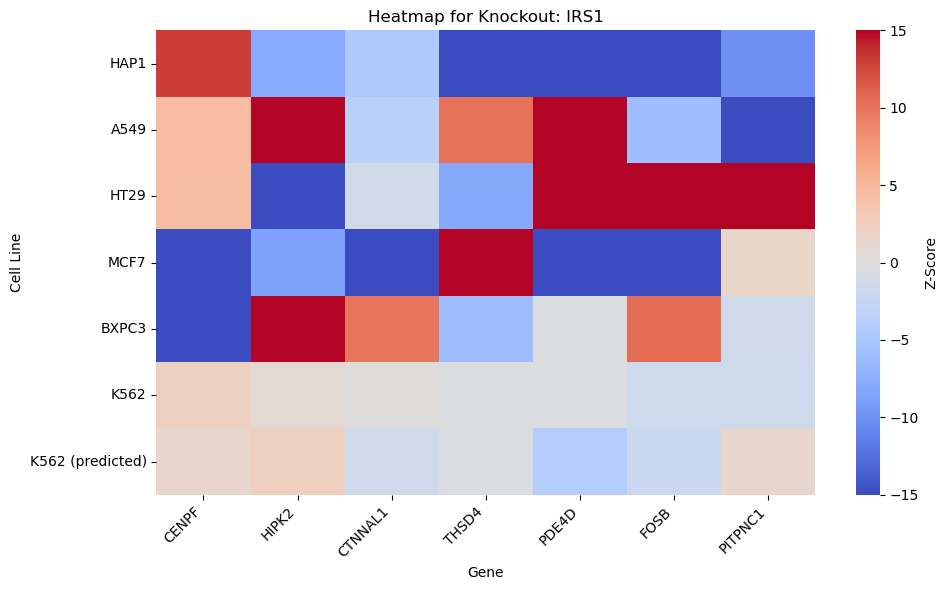

/tmp/ipykernel_2841245/2456622570.py:133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  knockout_df['cell_line'] = pd.Categorical(knockout_df['cell_line'], categories=cell_line_order, ordered=True)


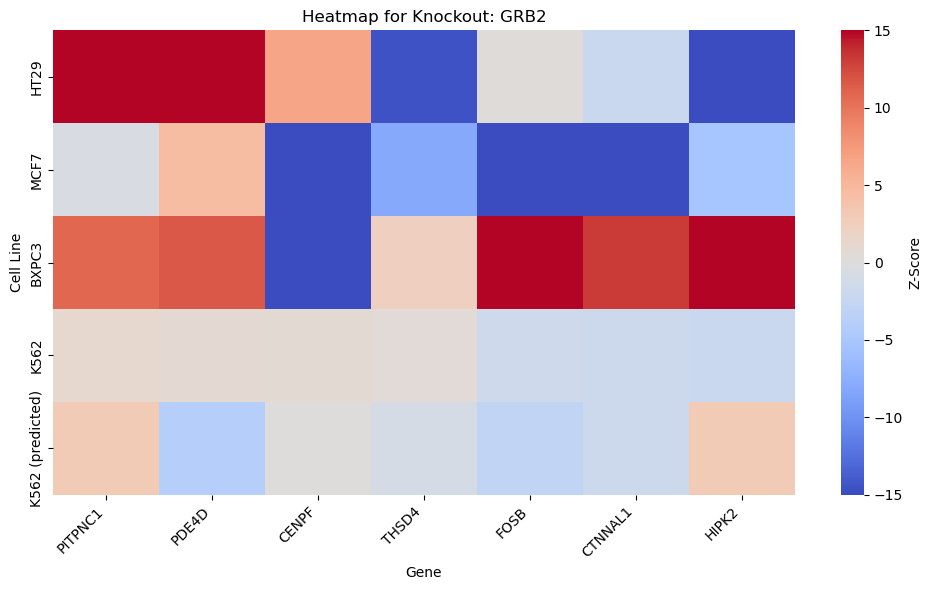

/tmp/ipykernel_2841245/2456622570.py:133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  knockout_df['cell_line'] = pd.Categorical(knockout_df['cell_line'], categories=cell_line_order, ordered=True)


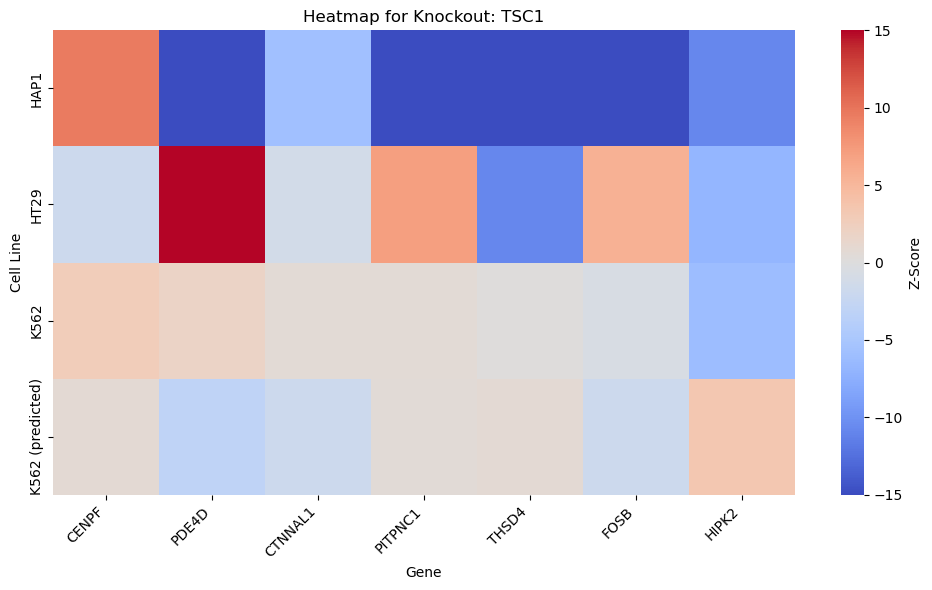

/tmp/ipykernel_2841245/2456622570.py:133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  knockout_df['cell_line'] = pd.Categorical(knockout_df['cell_line'], categories=cell_line_order, ordered=True)


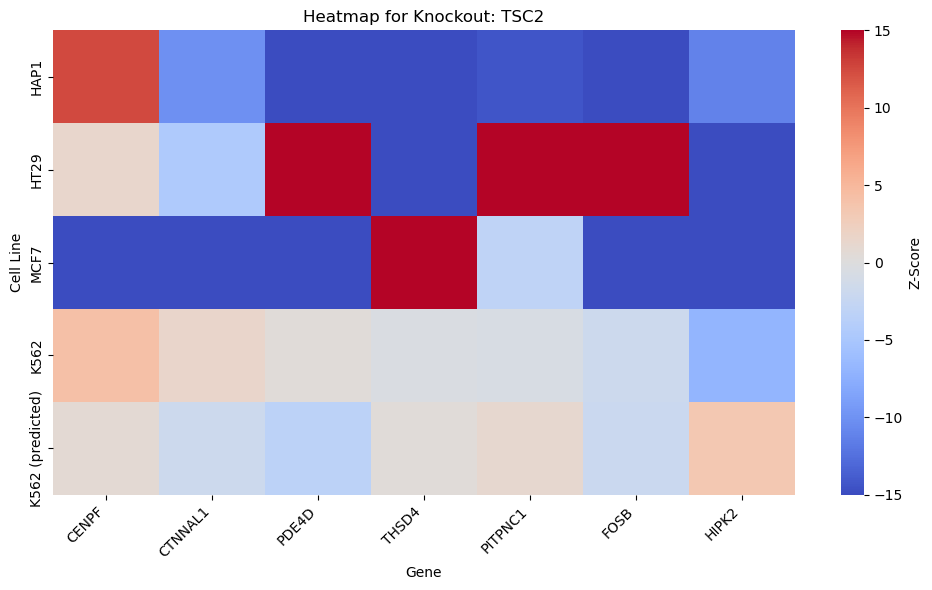

In [15]:
knockouts = ["GRB2", "IRS1", "TSC1", "TSC2"]
pathways = [ood_pathway]
cell_types = [f'{ood_cell_line} (predicted)', 'BXPC3', 'HAP1', 'K562', 'A549', 'HT29', 'MCF7']
genes = ["THSD4", "PITPNC1", "PDE4D", "LRRC8C", "IGF2BP2", "HIPK2", "FOSB", "CTNNAL1", "CMSS1", "CENPF"]

df = df_zscores[
    df_zscores['knockout'].isin(knockouts) &
    df_zscores['pathway'].isin(pathways) &
    df_zscores['cell_line'].isin(cell_types) &
    df_zscores['gene'].isin(genes)
]

remaining_cell_lines = [c for c in cell_line_order if ood_cell_line not in c]
plot_heatmaps_by_knockout_ordered(df, cell_line_order = remaining_cell_lines + [ood_cell_line, f'{ood_cell_line} (predicted)'])

In [16]:
df_results = calculate_similarities(df_predicted_filtered, df_ground_truth_filtered)
df_results

,cell_line_predicted,cell_line,pearson_correlation,spearman_correlation,MAE
0,K562 (predicted),A549,0.070160,-0.002742,16.439829
1,K562 (predicted),BXPC3,0.063613,0.020373,15.947758
2,K562 (predicted),HAP1,0.099272,0.044872,16.789402
3,K562 (predicted),HT29,0.109003,0.055201,16.735197
4,K562 (predicted),K562,0.317623,0.559475,7.793880
5,K562 (predicted),MCF7,0.091725,0.045789,17.377008


In [17]:
# quantification only for genes in heatmap
df_predicted_heatmaps = df_predicted_filtered.query('gene in @genes and knockout in @knockouts')
df_ground_truth_heatmaps = df_ground_truth_filtered.query('gene in @genes and knockout in @knockouts')
df_results_heatmaps = calculate_similarities(df_predicted_heatmaps, df_ground_truth_heatmaps)
df_results_heatmaps

,cell_line_predicted,cell_line,pearson_correlation,spearman_correlation,MAE
0,K562 (predicted),A549,-0.451319,-0.035714,15.295846
1,K562 (predicted),BXPC3,-0.005504,0.037363,14.135234
2,K562 (predicted),HAP1,0.726686,0.684416,26.922714
3,K562 (predicted),HT29,-0.543426,-0.492063,13.628859
4,K562 (predicted),MCF7,0.361506,0.468831,21.434502
5,K562 (predicted),K562,-0.284446,-0.087575,2.522845
